In [ ]:
%matplotlib inline
import pandas as pd
import numpy as np
import re
import time
import matplotlib.pyplot as plt

# Import the train and test datasets
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# Combine the two datasets
entire = pd.merge(train, test, how='outer')

In [ ]:
num_feat = list(entire.dtypes[entire.dtypes != 'object'].index)
categ_feat = list(entire.dtypes[entire.dtypes == 'object'].index)
print("Categorical features:", categ_feat)
print("Numerical features:", num_feat)

Categorical features: ['Name', 'Sex', 'Ticket', 'Cabin', 'Embarked']
Numerical features: ['PassengerId', 'Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare']


In [ ]:
features_without_Survived = [f for f in num_feat + categ_feat if f != 'Survived']
# Call describe method on the two main sets. First, the training set.
print(entire[entire.Survived.notnull()].describe())

       PassengerId    Survived      Pclass         Age       SibSp  \
count   891.000000  891.000000  891.000000  714.000000  891.000000   
mean    446.000000    0.383838    2.308642   29.699118    0.523008   
std     257.353842    0.486592    0.836071   14.526497    1.102743   
min       1.000000    0.000000    1.000000    0.420000    0.000000   
25%     223.500000    0.000000    2.000000   20.125000    0.000000   
50%     446.000000    0.000000    3.000000   28.000000    0.000000   
75%     668.500000    1.000000    3.000000   38.000000    1.000000   
max     891.000000    1.000000    3.000000   80.000000    8.000000   

            Parch        Fare  
count  891.000000  891.000000  
mean     0.381594   32.204208  
std      0.806057   49.693429  
min      0.000000    0.000000  
25%      0.000000    7.910400  
50%      0.000000   14.454200  
75%      0.000000   31.000000  
max      6.000000  512.329200  


In [ ]:
print(entire[entire.Survived.isnull()].describe())

       PassengerId  Survived      Pclass         Age       SibSp       Parch  \
count   418.000000       0.0  418.000000  332.000000  418.000000  418.000000   
mean   1100.500000       NaN    2.265550   30.272590    0.447368    0.392344   
std     120.810458       NaN    0.841838   14.181209    0.896760    0.981429   
min     892.000000       NaN    1.000000    0.170000    0.000000    0.000000   
25%     996.250000       NaN    1.000000   21.000000    0.000000    0.000000   
50%    1100.500000       NaN    3.000000   27.000000    0.000000    0.000000   
75%    1204.750000       NaN    3.000000   39.000000    1.000000    0.000000   
max    1309.000000       NaN    3.000000   76.000000    8.000000    9.000000   

             Fare  
count  417.000000  
mean    35.627188  
std     55.907576  
min      0.000000  
25%      7.895800  
50%     14.454200  
75%     31.500000  
max    512.329200  


In [ ]:
def show_nan(df):
    if True not in df[features_without_Survived].isnull().values:
        print("The entire dataset does not contain missing value.")
    else:
        print("The entire dataset contains:")
        for c in df.columns:
            if (c != 'Survived') & (True in df[c].isnull().values):
                l = [df[c].isnull().value_counts()[True], 
                     round((df[c].isnull().value_counts()[True] /\
                            df.PassengerId.count()), 5),
                     c]
                msg = ("\t- {} ({:.1%}) missing values for feature"
                       " '{}'".format(*l))
                print(msg)

In [ ]:
show_nan(entire)

The entire dataset contains:
	- 263 (20.1%) missing values for feature 'Age'
	- 1 (0.1%) missing values for feature 'Fare'
	- 1014 (77.5%) missing values for feature 'Cabin'
	- 2 (0.2%) missing values for feature 'Embarked'


In [ ]:
entire.Name[entire.Age.isnull()].head(3)

5                 Moran, Mr. James
17    Williams, Mr. Charles Eugene
19         Masselmani, Mrs. Fatima
Name: Name, dtype: object

In [ ]:
def plot_bar(df, feat_x, feat_y, normalize=True):
    """ Plot with vertical bars of the requested dataframe and features"""
    
    ct = pd.crosstab(df[feat_x], df[feat_y])
    if normalize == True:
        ct = ct.div(ct.sum(axis=1), axis=0)
    return ct.plot(kind='bar', stacked=True)

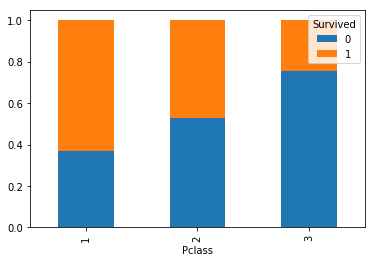

In [ ]:
plot_bar(train, 'Pclass', 'Survived')
plt.show()

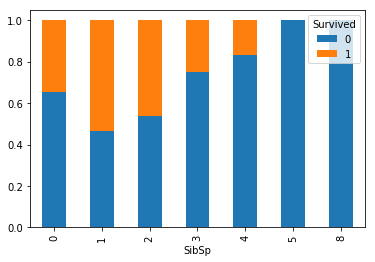

In [ ]:
plot_bar(train, 'SibSp', 'Survived')
plt.show()

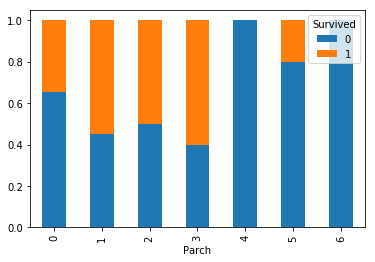

In [ ]:
plot_bar(train, 'Parch', 'Survived')
plt.show()

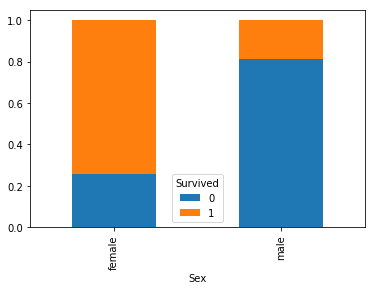

In [ ]:
# Plot the survival rates of the different "Sex" feature
plot_bar(train, 'Sex', 'Survived')
plt.show()

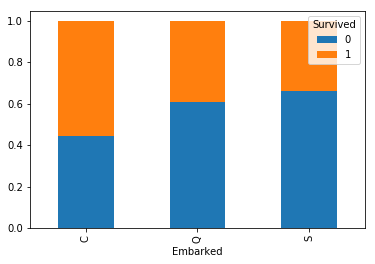

In [ ]:
plot_bar(train, 'Embarked', 'Survived')
plt.show()

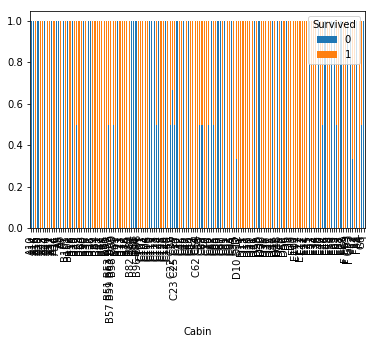

In [ ]:
plot_bar(train, 'Cabin', 'Survived')
plt.show()

In [ ]:
def create_status(name):
    """From "Name" feature extract the status"""
    m = re.search(" [A-Za-z]+\.", name)
    if m:
        status = re.sub('\.', '', re.sub(" ", "", m.group(0)))
        return status
    else:
        return "None"

for df in [entire, train]:
    df['Status'] = df['Name'].apply(create_status)
    df = df.drop(['Name'], axis=1)

In [ ]:
entire.Status.value_counts()

Mr          757
Miss        260
Mrs         197
Master       61
Rev           8
Dr            8
Col           4
Major         2
Ms            2
Mlle          2
Sir           1
Lady          1
Mme           1
Jonkheer      1
Dona          1
Countess      1
Capt          1
Don           1
Name: Status, dtype: int64

In [ ]:
# List the rare status to group in one "Rare" group
list_rare = ['Dr', 'Rev', 'Col', 'Major', 'Sir', 'Lady',
             'Dona', 'Don', 'Jonkheer', 'Countess', 'Capt']

for df in [entire, train]:
    # "Mme", is the French equivalent of "Mrs"
    df['Status'] = df['Status'].replace(["Mme", "Ms"], "Mrs")
    # "Mlle": "Miss"
    df['Status'] = df['Status'].replace(["Mlle"], "Miss")
    # Create "Rare" status
    df['Status'] = df['Status'].replace(list_rare, "Rare")
# Print the final 'Status' for each dataset
print("\nNumber of counts per 'Status' value in the entire dataset:")
print(entire['Status'].value_counts())


Number of counts per 'Status' value in the entire dataset:
Mr        757
Miss      262
Mrs       200
Master     61
Rare       29
Name: Status, dtype: int64


`Status` feature being created, we can now plot its correlation with the survival rate using the training set.

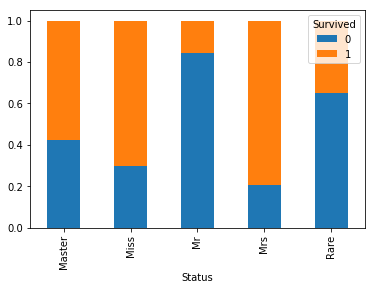

In [ ]:
plot_bar(train, 'Status', 'Survived')
plt.show()

In [ ]:
def family_size(number):
    if number == 1:
        return 'single'
    if 2 <= number <= 3:
        return 'small_family'
    if 4 <= number <= 5:
        return 'medium_family'
    if number > 5:
        return 'large_family'
    
for df in [entire, train]:
    df['FamilySize'] = df['SibSp'] + df['Parch'] + 1
    df['FamilySize'] = df['FamilySize'].apply(family_size)

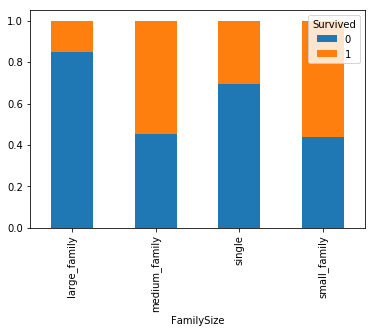

In [ ]:
plot_bar(train, 'FamilySize', 'Survived')
plt.show()

In [ ]:
entire['Embarked'] = entire['Embarked'].fillna("S")

In [ ]:
entire[entire.Fare.isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Status,FamilySize
1043,1044,NaN,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,NaN,NaN,S,Mr,single


In [ ]:
# Mr. Storey travelled in 3rd class. Let's find out the median value on the entire dataset:
link_fare_pclass = entire.groupby('Pclass')['Fare'].median()
link_fare_pclass

Pclass
1    60.0000
2    15.0458
3     8.0500
Name: Fare, dtype: float64

In [ ]:
# We can then fill in the missing value
entire.Fare = entire.Fare.fillna(link_fare_pclass[3])

In [ ]:
entire.Cabin = entire.Cabin.fillna('Unknown')
entire.Cabin = entire.Cabin.apply(lambda cabin_name: cabin_name[0])

# Return to np.nan values thanks to replace method
entire.Cabin = entire.Cabin.replace('U', np.nan)

# Create a groupby object grouping the entire dataset by "Ticket"
gbyTicket = entire.groupby('Ticket')

In [ ]:
# Now we will focus on the groups of gbyTicket that contain both missing and non missing
# values for Cabin feature
# The missing values will eventually be replaced by the value of the others
dict_ticket_cabin = {}
for ti, gr in gbyTicket:
    if (True in gr['Cabin'].isnull().values) and\
       (False in gr['Cabin'].isnull().values):
        print("\n******************** Ticket n°{} ********************".format(ti))
        print(gr[['Cabin', 'Pclass', 'Fare', 'SibSp', 'Parch',
                  'FamilySize', 'Embarked']])
        # Fill in dict_ticket_cabin with the corresponding cabin values,
        # when a "Ticket" value is shared
        dict_ticket_cabin[ti] = gr['Cabin'].describe()['top']
    else:
        # Fill in dict_ticket_cabin when no "Ticket" value is shared in the group
        # grouped by "Ticket"
        dict_ticket_cabin[ti] = 'U'


******************** Ticket n°113781 ********************
     Cabin  Pclass    Fare  SibSp  Parch     FamilySize Embarked
297      C       1  151.55      1      2  medium_family        S
305      C       1  151.55      1      2  medium_family        S
498      C       1  151.55      1      2  medium_family        S
708    NaN       1  151.55      0      0         single        S
1032   NaN       1  151.55      0      0         single        S
1197     C       1  151.55      1      2  medium_family        S

******************** Ticket n°17421 ********************
    Cabin  Pclass      Fare  SibSp  Parch    FamilySize Embarked
306   NaN       1  110.8833      0      0        single        C
550     C       1  110.8833      0      2  small_family        C
581     C       1  110.8833      1      1  small_family        C
698     C       1  110.8833      1      1  small_family        C

******************** Ticket n°19877 ********************
    Cabin  Pclass   Fare  SibSp  Parch    Fam

We can see that 16 `Cabin` missing values can be filled with their corresponding group value. `dict_ticket_cabin` was created in the previous cell in order to link the ticket number to the corresponding cabin name.
Every `Cabin` missing value linked to a same `Ticket` value is linked to the corresponding shared `Cabin` value. If no `Ticket` value is shared, then "U" will be provided to the `Cabin` missing value.

In [ ]:
# Function allowing filling missing values with the ones contained in "dict_mean_ages" dictionary
# Groups have a "name" attribute set internally, we then can use that:
fill_cabin_from_dict = lambda g: g.fillna(dict_ticket_cabin[g.name])

In [ ]:
#Before filling in the "Cabin" missing data, let's use "show_nan" function
show_nan(entire)

The entire dataset contains:
	- 263 (20.1%) missing values for feature 'Age'
	- 1014 (77.5%) missing values for feature 'Cabin'


In [ ]:
entire['Cabin'] = entire.groupby('Ticket')['Cabin'].apply(fill_cabin_from_dict)

# Use show_nan again to see if "fill_cabin_from_dict" worked
show_nan(entire)

The entire dataset contains:
	- 263 (20.1%) missing values for feature 'Age'


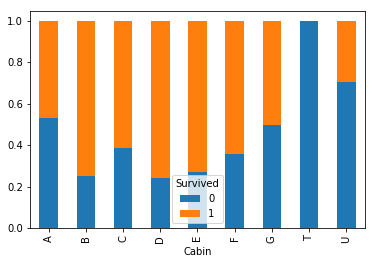

In [ ]:
train['Cabin'] = entire.groupby('Ticket')['Cabin'].apply(fill_cabin_from_dict)
plot_bar(train, 'Cabin', 'Survived')
plt.show()

In [ ]:
age_median = entire.groupby(['Status', 'Pclass'])['Age'].agg(['median', 'count'])
age_median = age_median.reset_index()
age_median

,Status,Pclass,median,count
0,Master,1,6.0,5
1,Master,2,2.0,11
2,Master,3,6.0,37
3,Miss,1,30.0,61
4,Miss,2,20.0,48
5,Miss,3,18.0,103
6,Mr,1,41.5,132
7,Mr,2,30.0,137
8,Mr,3,26.0,312
9,Mrs,1,45.0,68


We can now fill in the `Age` missing values with these median values.

In [ ]:
for index in entire[entire.Age.isnull()].index:
    median = age_median[(age_median.Status == entire.iloc[index]['Status']) &\
                        (age_median.Pclass == entire.iloc[index]['Pclass'])\
                       ]['median'].values[0]
    entire.set_value(index, 'Age', median)

C:\Users\dell\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
show_nan(entire)

The entire dataset does not contain missing value.


In [ ]:
categ_age = pd.qcut(entire.Age, 8, labels=range(8), retbins=True)
entire['Age_category'] = categ_age[0]

In [ ]:
categ_fare = pd.qcut(entire.Fare, 8, labels=range(8), retbins=True)
entire['Fare_category'] = categ_fare[0]

In [ ]:
entire = entire.drop(['Ticket', 'PassengerId',  'Name',
                      'SibSp', 'Parch', 'Age', 'Fare'],
                     axis=1)

In [ ]:
# Ordered features transformation
ordered = {
    'Pclass': [3, 2, 1],
    'FamilySize': ['single', 'small_family', 'medium_family', 'large_family'],
}
for feat, val in ordered.items():
    entire[feat] = entire[feat].astype('category',
                                       categories=val,
                                       ordered=True).cat.codes

# Non-ordered features transformation
non_ordered = ['Sex', 'Status', 'Embarked', 'Cabin']
entire = pd.get_dummies(entire, columns=non_ordered, drop_first=True)

C:\Users\dell\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: FutureWarning: specifying 'categories' or 'ordered' in .astype() is deprecated; pass a CategoricalDtype instead
  if __name__ == '__main__':


In [ ]:
#List of features for train set
feat_train = entire.columns.values
# List of features for test set
feat_test = [feat for feat in feat_train if feat != 'Survived']

In [ ]:
# Create the (X, y) training vectors to be injected in ours classifiers
X_train = entire[entire.Survived.notnull()].drop(['Survived'], axis=1)
y_train = entire[entire.Survived.notnull()]['Survived']

# Split the training set into a development and an evaluation sets
from sklearn.model_selection import train_test_split
X_dev, X_eval, y_dev, y_eval = train_test_split(X_train,
                                                y_train,
                                                test_size=0.2,
                                                random_state=42)
# And the test set
X_test = entire[entire.Survived.isnull()].drop(['Survived'], axis=1)

In [ ]:
# Import classifiers
from sklearn.ensemble import (RandomForestClassifier,
                              GradientBoostingClassifier,
                              AdaBoostClassifier)

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve,auc
import sklearn.metrics as metrics

RandomForestClassifier:
	Mean accuracy on development set	= 0.819 (+/- 0.015)
	Accuracy on evaluation set		= 0.832
	Confusion matrix on evaluation set
[[92 13]
 [17 57]]
	ROC AUC on evaluation set
0.8232303732303732


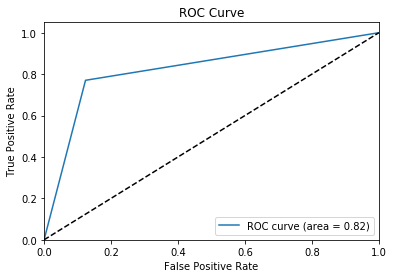

GradientBoostingClassifier:
	Mean accuracy on development set	= 0.827 (+/- 0.032)
	Accuracy on evaluation set		= 0.832
	Confusion matrix on evaluation set
[[90 15]
 [15 59]]
	ROC AUC on evaluation set
0.8272200772200773


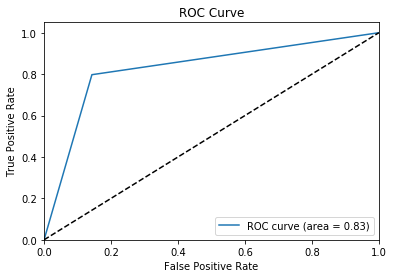

AdaBoostClassifier:
	Mean accuracy on development set	= 0.812 (+/- 0.025)
	Accuracy on evaluation set		= 0.821
	Confusion matrix on evaluation set
[[87 18]
 [14 60]]
	ROC AUC on evaluation set
0.8196911196911196


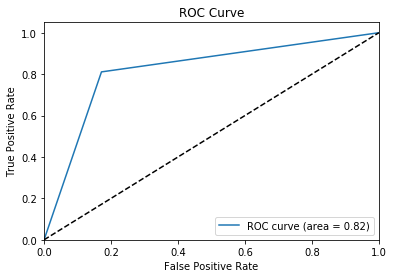

In [ ]:
# Use them without any hyperparameters tuning
models = [RandomForestClassifier(random_state=77),
          GradientBoostingClassifier(random_state=77),
          AdaBoostClassifier(random_state=77)]

from sklearn.model_selection import cross_val_score, GridSearchCV

for model in models:
    score = cross_val_score(model, X_dev, y_dev, cv=5)
    msg = ("{0}:\n\tMean accuracy on development set\t= {1:.3f} "
           "(+/- {2:.3f})".format(model.__class__.__name__,
                                  score.mean(),
                                  score.std()))
    print(msg)
    
    # Fit the model on the dev set and predict and eval independent set
    model.fit(X_dev, y_dev)
    pred_eval = model.predict(X_eval)
    acc_eval = accuracy_score(y_eval, pred_eval)
    cm = confusion_matrix(y_eval, pred_eval)
      
    print("\tAccuracy on evaluation set\t\t= {0:.3f}".format(acc_eval))
    print("\tConfusion matrix on evaluation set")
    print(cm)
    
    fpr, tpr, _ = roc_curve(y_eval, pred_eval)

    # Calculate the AUC
    roc_auc = auc(fpr, tpr)
    print("\tROC AUC on evaluation set")
    print(roc_auc)

    # Plot of a ROC curve for a specific class
    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

The models having the lowest standard deviation are RandomForest and AdaBoost, which indicates that the variance of these models is quite low, which is what we're looking for in order to finally obtain a model that can generalize well. Over these three models, the least biased is the AdaBoost model as the difference between its development and evaluation sets accuracies is the smallest. The best accuracies over the evaluation set are obtained with RandomForest and GradientBoosting.
Scaling isn't necessary as these three models are not sensitive to data scaling.

Let's tune the hyperparameters with our three classifiers. The `dict_clf` dictionary will be filled in with the estimators names, their best parameters combination, best score and fitting time.
Nota: the calculation time being limited for kernels, I reduced the size of my grid of parameter values, which will affect the final accuracy. One can expand the range of paramgrid keys values in order to improve your score!

In [ ]:
# Import time module in order to get the time spent by GridSearchCV with all the
# different classifiers
import time
dict_clf = {}

In [ ]:
# 1. Random Forest
paramgrid = {
    'n_estimators':      [100, 200, 500, 750, 1000],
    'criterion':         ['gini', 'entropy'],
    'max_features':      ['auto', 'log2'],
    'min_samples_leaf':  list(range(2, 7))
}
GS = GridSearchCV(RandomForestClassifier(random_state=77),
                  paramgrid,
                  cv=4)
t0 = time.time()
GS.fit(X_dev, y_dev)
t = time.time() - t0
best_clf = GS.best_estimator_
best_params = GS.best_params_
best_score = GS.best_score_
name = 'RF'
best_clf.fit(X_dev, y_dev)
acc_eval = accuracy_score(y_eval, best_clf.predict(X_eval))
dict_clf[name] = {
    'best_par': best_params,
    'best_clf': best_clf,
    'best_score': best_score,
    'score_eval': acc_eval,
    'fit_time': t,
}

In [ ]:
# 2. GradientBoosting
paramgrid = {
    'n_estimators':      [100, 200, 500, 750, 1000],
    'max_features':      ['auto', 'log2'],
    'min_samples_leaf':  list(range(2, 7)),
    'loss' :             ['deviance', 'exponential'],
    'learning_rate':     [0.05, 0.1, 0.2],
}
GS = GridSearchCV(GradientBoostingClassifier(random_state=77),
                  paramgrid,
                  cv=4)
t0 = time.time()
GS.fit(X_dev, y_dev)
t = time.time() - t0
best_clf = GS.best_estimator_
best_params = GS.best_params_
best_score = GS.best_score_
name = 'GB'
best_clf.fit(X_dev, y_dev)
acc_eval = accuracy_score(y_eval, best_clf.predict(X_eval))
dict_clf[name] = {
    'best_par': best_params,
    'best_clf': best_clf,
    'best_score': best_score,
    'score_eval': acc_eval,
    'fit_time': t,
}

In [ ]:
# 3. AdaBoost
paramgrid = {
    'n_estimators':  [100, 200, 500, 750, 1000],
    'learning_rate': [0.05, 0.1, 0.5, 1, 2]
}
GS = GridSearchCV(AdaBoostClassifier(random_state=77),
                  paramgrid,
                  cv=4)
t0 = time.time()
GS.fit(X_dev, y_dev)
t = time.time() - t0
best_clf = GS.best_estimator_
best_params = GS.best_params_
best_score = GS.best_score_
name = 'ADB'
best_clf.fit(X_dev, y_dev)
acc_eval = accuracy_score(y_eval, best_clf.predict(X_eval))
dict_clf[name] = {
    'best_par': best_params,
    'best_clf': best_clf,
    'best_score': best_score,
    'score_eval': acc_eval,
    'fit_time': t,
}

Print all these informations about our classifiers after hyperparameters tuning:

In [ ]:
for clf in dict_clf.keys():
    print("{0} classifier:\n\t- Best score = {1:.2%}".format(clf, dict_clf[clf]['best_score']))
    print("\t- Score on evaluation set = {0:.2%}".format(dict_clf[clf]['score_eval']))
    print("\t- Fitting time = {0:.1f} min".format(round(dict_clf[clf]['fit_time']/60, 1)))
    print("\t- Best parameters:")
    for par in sorted(dict_clf[clf]['best_par'].keys()):
        print("\t\t* {0}: {1}".format(par, dict_clf[clf]['best_par'][par]))

RF classifier:
	- Best score = 83.29%
	- Score on evaluation set = 82.68%
	- Fitting time = 4.2 min
	- Best parameters:
		* criterion: entropy
		* max_features: auto
		* min_samples_leaf: 4
		* n_estimators: 200
GB classifier:
	- Best score = 83.43%
	- Score on evaluation set = 81.56%
	- Fitting time = 6.0 min
	- Best parameters:
		* learning_rate: 0.05
		* loss: exponential
		* max_features: log2
		* min_samples_leaf: 5
		* n_estimators: 200
ADB classifier:
	- Best score = 81.32%
	- Score on evaluation set = 80.45%
	- Fitting time = 1.6 min
	- Best parameters:
		* learning_rate: 0.05
		* n_estimators: 750
